In [6]:
from matplotlib.animation import FuncAnimation
from magnipy import Magnipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

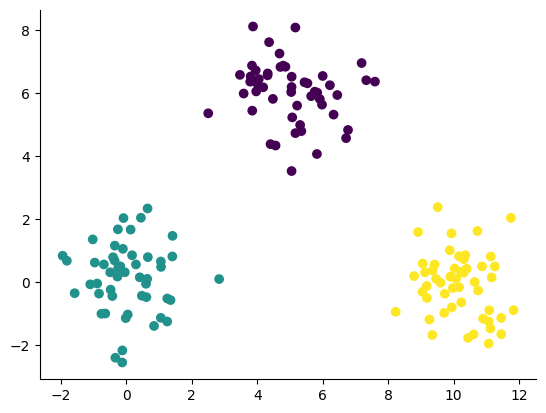

In [7]:
def sample_points_gaussian(mean, cov, n):
    points = np.random.multivariate_normal(mean, cov, n)
    return points

np.random.seed(4)
mean1 = [5, 6]
cov1 = np.eye(2) * 1.1

size = 50
points1 = sample_points_gaussian(mean1, cov1, size)

more_points1 = sample_points_gaussian(mean1, cov1, size*2)

points2 = sample_points_gaussian([0, 0], cov1, size)

points3 = sample_points_gaussian([10, 0], cov1, size)

make_blobs = np.concatenate([points1, points2, points3], axis=0)

colors = np.array(np.concatenate([np.zeros(size), np.ones(size), np.ones(size) * 2]))

plt.scatter(make_blobs[:, 0], make_blobs[:, 1], c=colors)
sns.despine()

MovieWriter ffmpeg unavailable; using Pillow instead.


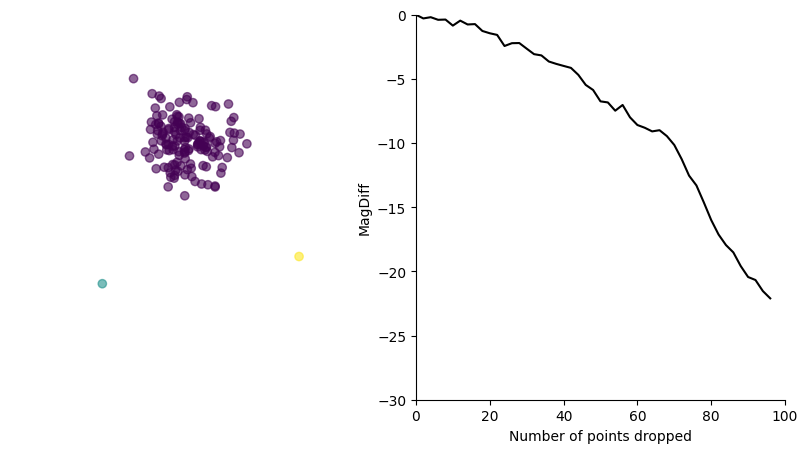

In [10]:
x = make_blobs[:, 0]
y = make_blobs[:, 1]
color_values = colors

fig, ax = plt.subplots(figsize=(10, 5))
scat = ax.scatter(x, y, c=color_values, cmap='viridis', alpha=0.6)

mag_start = Magnipy(make_blobs, n_ts=100)
ts = mag_start.get_scales()
mag_ref, tss = mag_start.get_magnitude()

mag_area0 = mag_start.MagArea(scale=True)

mag_diffs=[]
for frame in range(size):
    X_new = np.concatenate([points1, points2[:(size-frame)], points3[:(size-frame)], more_points1[:(2*(frame))]], axis=0)
    new_colors = np.concatenate([np.zeros(size), np.ones(size-frame), np.ones(size-frame) * 2, np.zeros(2*(frame))])
    new_x = X_new[:,0]
    new_y = X_new[:,1]

    mag_new = Magnipy(X_new, ts=ts)
    mag, tss = mag_new.get_magnitude()
    mag_area = mag_new.MagArea(scale=True)

    mag_diff = mag_start.MagDiff(mag_new, scale=True)
    mag_diffs.append(-mag_diff)

def update(frame):
    fig.clear()
    # Remove one point at a time
    X_new = np.concatenate([points1, points2[:(size-frame)], points3[:(size-frame)], more_points1[:(2*(frame))]], axis=0)
    new_colors = np.concatenate([np.zeros(size), np.ones(size-frame), np.ones(size-frame) * 2, np.zeros(2*(frame))])
    new_x = X_new[:,0]
    new_y = X_new[:,1]

    ax1 = fig.add_subplot(121, aspect='equal', autoscale_on=False, xlim=(-3, 14), ylim=(-4, 10))
    ax1.scatter(new_x, new_y, c=new_colors, cmap='viridis', alpha=0.6)
    ax1.set_axis_off()

    ax2 = fig.add_subplot(122, aspect='equal', autoscale_on=True, xlim=(0, size*2), ylim=(-30, 0))
    ax2.plot([r*2 for r in range(frame)], mag_diffs[:frame], label='Magnitude', color='black')
    ax2.set_aspect(aspect='auto')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xlabel('Number of points dropped')
    ax2.set_ylabel('MagDiff')
    plt.subplots_adjust(wspace=0.1) 

# Create animation
ani = FuncAnimation(fig, update, frames=size, repeat=False, interval=int(500/1*size))
ani.save('./assets/mode_dropping.gif', fps=10)

plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


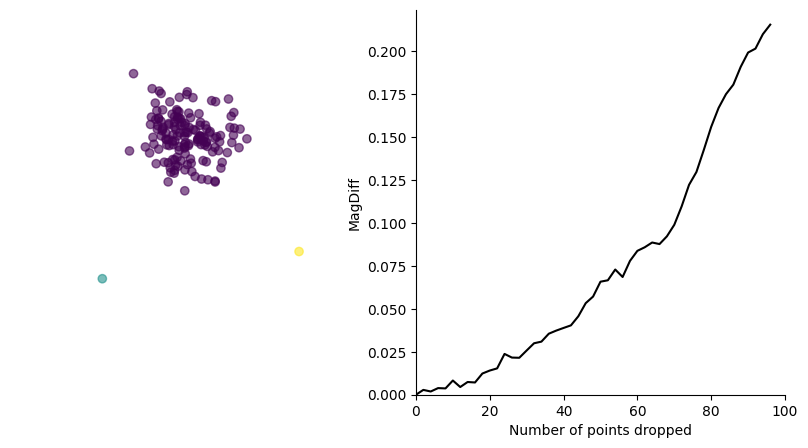

In [11]:
x = make_blobs[:, 0]
y = make_blobs[:, 1]
color_values = colors

fig, ax = plt.subplots(figsize=(10, 5))
scat = ax.scatter(x, y, c=color_values, cmap='viridis', alpha=0.6)

mag_start = Magnipy(make_blobs, n_ts=100)
ts = mag_start.get_scales()
mag_ref, tss = mag_start.get_magnitude()

mag_area0 = mag_start.MagArea(scale=True)

mag_diffs=[]
for frame in range(size):
    X_new = np.concatenate([points1, points2[:(size-frame)], points3[:(size-frame)], more_points1[:(2*(frame))]], axis=0)
    new_colors = np.concatenate([np.zeros(size), np.ones(size-frame), np.ones(size-frame) * 2, np.zeros(2*(frame))])
    new_x = X_new[:,0]
    new_y = X_new[:,1]

    mag_new = Magnipy(X_new, ts=ts)
    mag, tss = mag_new.get_magnitude()
    mag_area = mag_new.MagArea(scale=True)

    mag_diff = mag_start.MagDiff(mag_new, scale=True)
    mag_diffs.append(mag_diff/mag_area0)

def update(frame):
    fig.clear()
    # Remove one point at a time
    X_new = np.concatenate([points1, points2[:(size-frame)], points3[:(size-frame)], more_points1[:(2*(frame))]], axis=0)
    new_colors = np.concatenate([np.zeros(size), np.ones(size-frame), np.ones(size-frame) * 2, np.zeros(2*(frame))])
    new_x = X_new[:,0]
    new_y = X_new[:,1]

    ax1 = fig.add_subplot(121, aspect='equal', autoscale_on=False, xlim=(-3, 14), ylim=(-4, 10))
    ax1.scatter(new_x, new_y, c=new_colors, cmap='viridis', alpha=0.6)
    ax1.set_axis_off()

    ax2 = fig.add_subplot(122, aspect='equal', autoscale_on=True, xlim=(0, size*2), ylim=(min(mag_diffs), max(mag_diffs)))
    ax2.plot([r*2 for r in range(frame)], mag_diffs[:frame], label='Magnitude', color='black')
    ax2.set_aspect(aspect='auto')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xlabel('Number of points dropped')
    ax2.set_ylabel('MagDiff')
    plt.subplots_adjust(wspace=0.1) 

# Create animation
ani = FuncAnimation(fig, update, frames=size, repeat=False, interval=int(500/1*size))
ani.save('./assets/mode_dropping_normalised.gif', fps=10)

plt.show()